In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from tqdm import tqdm
import time

train = pd.read_csv("CSV_train.csv",low_memory=False,delimiter=';')
test=pd.read_csv("CSV_test.csv",low_memory=False,delimiter=',')
hidden=pd.read_csv("CSV_hidden_test.csv",low_memory=False,delimiter=',')

In [2]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136786 entries, 0 to 136785
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WELL                              136786 non-null  object 
 1   DEPTH_MD                          136786 non-null  float64
 2   X_LOC                             136727 non-null  float64
 3   Y_LOC                             136727 non-null  float64
 4   Z_LOC                             136727 non-null  float64
 5   GROUP                             136786 non-null  object 
 6   FORMATION                         129712 non-null  object 
 7   CALI                              131141 non-null  float64
 8   RSHA                              39097 non-null   float64
 9   RMED                              136199 non-null  float64
 10  RDEP                              136727 non-null  float64
 11  RHOB                              119826 non-null  f

In [3]:
# storing length of datasets 
train_len = train.shape[0] 
test_len = test.shape[0]
All_data = pd.concat((train,test,hidden)).reset_index(drop=True) 

lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}
All_data['Lithology'] = All_data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)
All_data

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Lithology
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0,Shale
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0,Shale
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0,Shale
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0,Shale
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,...,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,35/9-7,2973.2988,536096.06250,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,2.820439,...,136.911575,NaN,0.502458,NaN,2.311106,24.306124,NaN,65000,2.0,Shale
1429690,35/9-7,2973.4508,536096.06250,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.020778,...,137.583923,NaN,0.374753,NaN,1.853418,22.201078,NaN,65000,2.0,Shale
1429691,35/9-7,2973.6028,536096.06250,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,2.795711,...,138.310898,NaN,0.211487,NaN,1.325961,20.096741,NaN,65000,2.0,Shale
1429692,35/9-7,2973.7548,536096.06250,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.658694,...,137.592819,NaN,0.147950,NaN,1.260347,17.992323,NaN,65000,2.0,Shale


In [4]:
#dropping columns with high missing values
drop_cols = ['SGR', 'ROPA', 'RXO', 'MUDWEIGHT','DCAL','RMIC','FORCE_2020_LITHOFACIES_CONFIDENCE','FORCE_2020_LITHOFACIES_LITHOLOGY','RMED','DRHO','ROP','SP','PEF','BS']
All_data_drop = All_data.drop(drop_cols, axis=1)


In [5]:
All_data_drop

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RDEP,RHOB,GR,NPHI,DTC,DTS,Lithology
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.798681,1.884186,80.200851,NaN,161.131180,NaN,Shale
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.795641,1.889794,79.262886,NaN,160.603470,NaN,Shale
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.800733,1.896523,74.821999,NaN,160.173615,NaN,Shale
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.801517,1.891913,72.878922,NaN,160.149429,NaN,Shale
4,15/9-13,495.1360,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.795299,1.880034,71.729141,NaN,160.128342,NaN,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,35/9-7,2973.2988,536096.06250,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,3.158570,NaN,90.720284,NaN,75.260658,136.911575,Shale
1429690,35/9-7,2973.4508,536096.06250,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.332977,NaN,87.062027,NaN,74.868301,137.583923,Shale
1429691,35/9-7,2973.6028,536096.06250,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,3.044179,NaN,86.115921,NaN,74.848122,138.310898,Shale
1429692,35/9-7,2973.7548,536096.06250,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.847681,NaN,89.497131,NaN,74.964027,137.592819,Shale


In [6]:
All_data_drop.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC', 'DTS',
       'Lithology'],
      dtype='object')

In [7]:
#Inputing missing values by introducing median 
from sklearn.impute import SimpleImputer

numeric_header=['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC',
       'CALI', 'RSHA', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC','DTS']
categorical_header=['WELL','GROUP', 'FORMATION','Lithology']
numeric=All_data_drop.select_dtypes(include=[np.number])
categorical= All_data_drop.select_dtypes(exclude=[np.number])
miss = SimpleImputer(missing_values=np.nan, strategy='median')
miss.fit(numeric)
numeric_imp = miss.fit_transform(numeric)
numeric_imp=pd.DataFrame(numeric_imp, columns=numeric_header)
miss2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
miss2.fit(categorical)
categorical_imp = miss2.fit_transform(categorical)
categorical_imp=pd.DataFrame(categorical_imp, columns=categorical_header)
frames = [numeric_imp,categorical_imp]
  
result = pd.concat(frames,axis=1, join='inner')
result

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RDEP,RHOB,GR,NPHI,DTC,DTS,WELL,GROUP,FORMATION,Lithology
0,494.5280,437641.96875,6470972.5,-469.501831,19.480835,1.398049,1.798681,1.884186,80.200851,0.32374,161.131180,189.362198,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
1,494.6800,437641.96875,6470972.5,-469.653809,19.468800,1.398049,1.795641,1.889794,79.262886,0.32374,160.603470,189.362198,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
2,494.8320,437641.96875,6470972.5,-469.805786,19.468800,1.398049,1.800733,1.896523,74.821999,0.32374,160.173615,189.362198,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
3,494.9840,437641.96875,6470972.5,-469.957794,19.459282,1.398049,1.801517,1.891913,72.878922,0.32374,160.149429,189.362198,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
4,495.1360,437641.96875,6470972.5,-470.109772,19.453100,1.398049,1.795299,1.880034,71.729141,0.32374,160.128342,189.362198,15/9-13,NORDLAND GP.,Utsira Fm.,Shale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429689,2973.2988,536096.06250,6793022.0,-2943.444580,8.276272,1.398049,3.158570,2.331407,90.720284,0.32374,75.260658,136.911575,35/9-7,BAAT GP.,Etive Fm.,Shale
1429690,2973.4508,536096.06250,6793022.0,-2943.595947,8.267273,1.398049,3.332977,2.331407,87.062027,0.32374,74.868301,137.583923,35/9-7,BAAT GP.,Etive Fm.,Shale
1429691,2973.6028,536096.06250,6793022.0,-2943.747559,8.250099,1.398049,3.044179,2.331407,86.115921,0.32374,74.848122,138.310898,35/9-7,BAAT GP.,Etive Fm.,Shale
1429692,2973.7548,536096.06250,6793022.0,-2943.899170,12.515673,1.398049,2.847681,2.331407,89.497131,0.32374,74.964027,137.592819,35/9-7,BAAT GP.,Etive Fm.,Shale


In [8]:
# encoding categorical variables
result['GROUP_encoded'] = result['GROUP'].astype('category')
result['GROUP_encoded'] = result['GROUP_encoded'].cat.codes

result['FORMATION_encoded'] = result['FORMATION'].astype('category')
result['FORMATION_encoded'] = result['FORMATION_encoded'].cat.codes

result['WELL_encoded'] = result['WELL'].astype('category')
result['WELL_encoded'] = result['WELL_encoded'].cat.codes

result['Lithology_encoded'] = result['Lithology'].astype('category')
result['Lithology_encoded'] = result['Lithology_encoded'].cat.codes

In [9]:
train_imp = result[:train_len].copy()
test_imp = result[train_len:(train_len+test_len)].copy()
hidden_imp = result[(train_len+test_len):].copy()

In [10]:
print(train_imp.shape)
print(test_imp.shape)
print(hidden_imp.shape)

(1170511, 20)
(136786, 20)
(122397, 20)


In [11]:


# calculating p-impedance
train_imp['PI'] = train_imp.RHOB * (1e6/train_imp.DTC)
test_imp['PI'] = test_imp.RHOB * (1e6/test_imp.DTC)
hidden_imp['PI'] = hidden_imp.RHOB * (1e6/hidden_imp.DTC)

# calculating s-impedance
train_imp['SI'] = train_imp.RHOB * (1e6/train_imp.DTS) 
test_imp['SI'] = test_imp.RHOB * (1e6/test_imp.DTS) 
hidden_imp['SI'] = hidden_imp.RHOB * (1e6/hidden_imp.DTS) 

#calculating Shear modulus (G)
train_imp['G'] = ((1e6/train_imp.DTS)**2) * train_imp.RHOB
test_imp['G'] = ((1e6/test_imp.DTS)**2) * test_imp.RHOB
hidden_imp['G'] = ((1e6/hidden_imp.DTS)**2) * hidden_imp.RHOB

#calculating Bulk modulus (K)
train_imp['K'] = (((1e6/train_imp.DTC)**2) * train_imp.RHOB) - (4 * train_imp.G/3)
test_imp['K'] = (((1e6/test_imp.DTC)**2) * test_imp.RHOB) - (4 * test_imp.G/3)
hidden_imp['K'] = (((1e6/hidden_imp.DTC)**2) * hidden_imp.RHOB) - (4 * hidden_imp.G/3)

# calculate the shale volume
train_imp["VSHALE"] = (train_imp.GR - np.min(train_imp.GR)) / (np.max(train_imp.GR) - np.min(train_imp.GR))
test_imp["VSHALE"] = (test_imp.GR - np.min(test_imp.GR)) / (np.max(test_imp.GR) - np.min(test_imp.GR))
hidden_imp["VSHALE"] = (hidden_imp.GR - np.min(hidden_imp.GR)) / (np.max(hidden_imp.GR) - np.min(hidden_imp.GR))
#train_imp1.head()

# calculate the total porosity
train_imp['PHIT'] = np.sqrt(((((train_imp.NPHI)*(train_imp.NPHI)+(train_imp.RHOB)*(train_imp.RHOB))))/2)
test_imp['PHIT'] = np.sqrt(((((test_imp.NPHI)*(test_imp.NPHI)+(test_imp.RHOB)*(test_imp.RHOB))))/2)
hidden_imp['PHIT'] = np.sqrt(((((hidden_imp.NPHI)*(hidden_imp.NPHI)+(hidden_imp.RHOB)*(hidden_imp.RHOB))))/2)
#train_imp1.tail()

# calculate effective porosity
train_imp['PHIE'] = train_imp.PHIT*(1-train_imp.VSHALE)
train_imp = train_imp[train_imp['PHIE'] !=0]
train_imp['PHIE'] = train_imp['PHIE'].abs() 

test_imp['PHIE'] = test_imp.PHIT*(1-test_imp.VSHALE)
test_imp = test_imp[test_imp['PHIE'] !=0]
test_imp['PHIE'] = test_imp['PHIE'].abs() 

hidden_imp['PHIE'] = hidden_imp.PHIT*(1-hidden_imp.VSHALE)
hidden_imp = hidden_imp[hidden_imp['PHIE'] !=0]
hidden_imp['PHIE'] = hidden_imp['PHIE'].abs() 
#train_imp1.tail()

# # display the log for preview
# plt.figure(figsize=(5,10))
# plt.subplot(122)
# plt.title('PHIE')
# plt.plot('PHIE', 'SI','PI','G','K','VSHALE','DEPTH_MD', data=train_imp)
# plt.gca().invert_yaxis()

In [16]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
x_header=['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'DTC','DTS','K','G','VSHALE','PHIT','PHIE','SI','PI',
       'GROUP_encoded', 'FORMATION_encoded', 'WELL_encoded']
y_header=['Lithology_encoded']
x_train = train_imp[x_header]
y_train = train_imp[y_header]
x_test = test_imp[x_header]
y_test = test_imp[y_header]
x_hidden = hidden_imp[x_header]
y_hidden = hidden_imp[y_header]

##Min-Max scaler 
scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_hidden_scaled = x_hidden.copy()

x_train_scaled.iloc[:,:19] = scaler.fit_transform(x_train_scaled.iloc[:,:19])
x_test_scaled.iloc[:,:19] = scaler.transform(x_test_scaled.iloc[:,:19])
x_hidden_scaled.iloc[:,:19] = scaler.transform(x_hidden_scaled.iloc[:,:19])

In [17]:
x_train_scaled

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RDEP,RHOB,GR,NPHI,...,K,G,VSHALE,PHIT,PHIE,SI,PI,GROUP_encoded,FORMATION_encoded,WELL_encoded
0,0.067624,0.073718,0.142953,0.932176,0.660761,0.000637,0.000884,0.425020,0.077168,0.347272,...,0.008466,0.103092,0.077168,0.389828,0.504086,0.232190,0.023277,6,68,1
1,0.067652,0.073718,0.142953,0.932147,0.660297,0.000637,0.000882,0.427069,0.076264,0.347272,...,0.008479,0.103427,0.076264,0.391988,0.506116,0.233183,0.023562,6,68,1
2,0.067681,0.073718,0.142953,0.932118,0.660297,0.000637,0.000885,0.429527,0.071986,0.347272,...,0.008491,0.103829,0.071986,0.394580,0.510327,0.234373,0.023849,6,68,1
3,0.067710,0.073718,0.142953,0.932089,0.659930,0.000637,0.000885,0.427843,0.070113,0.347272,...,0.008491,0.103554,0.070113,0.392804,0.510098,0.233558,0.023744,6,68,1
4,0.067738,0.073718,0.142953,0.932061,0.659692,0.000637,0.000882,0.423503,0.069006,0.347272,...,0.008491,0.102843,0.069006,0.388228,0.507442,0.231456,0.023461,6,68,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170506,0.572248,0.355099,0.735606,0.625774,0.234400,0.000637,0.000711,0.660253,0.074715,0.347272,...,0.011803,0.141586,0.074715,0.638733,0.682184,0.346096,0.068605,11,7,117
1170507,0.572277,0.355099,0.735606,0.625774,0.232707,0.000637,0.000711,0.663771,0.072508,0.347272,...,0.011816,0.142162,0.072508,0.642466,0.686463,0.347800,0.068951,11,7,117
1170508,0.572305,0.355099,0.735606,0.625774,0.231589,0.000637,0.000711,0.647054,0.063922,0.347272,...,0.011755,0.139426,0.063922,0.624730,0.680059,0.339705,0.067307,11,7,117
1170509,0.572334,0.355099,0.735606,0.625774,0.230182,0.000637,0.000711,0.630860,0.053643,0.347272,...,0.011695,0.136776,0.053643,0.607554,0.675040,0.331863,0.065714,11,7,117


In [18]:
#Supervised Algorithms
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from pprint import pprint
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
#Comparing base models accuracies by using k-fold cross validation - 10 folds

from sklearn.model_selection import cross_val_score

model_rf = RandomForestClassifier()
                                    
model_rf_tuned = RandomForestClassifier(criterion='entropy',max_depth=20, max_features='auto', min_samples_leaf= 1, n_estimators=150)

# Fit the regressor to the training data
model_rf_tuned.fit(x_train_scaled, y_train.values.ravel())

# Prediction
train_pred_rf = model_rf_tuned.predict(x_train_scaled)
open_pred_rf = model_rf_tuned.predict(x_test_scaled)
hidden_pred_rf = model_rf_tuned.predict(x_hidden_scaled)
#Printing Reports 
#Printing Reports


In [19]:
A = np.load('penalty_matrix.npy')
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [20]:
from sklearn.metrics import classification_report, accuracy_score
print('-----------------------TRAIN SET REPORT---------------------')
print("Open set RMSE:", np.sqrt(mean_squared_error(y_train, train_pred_rf)))
print('Open set penalty matrix score:', score(y_train.values, train_pred_rf))
print('Open set report:', classification_report(y_train, train_pred_rf))
print('-----------------------OPEN SET REPORT---------------------')
print("Open set RMSE:", np.sqrt(mean_squared_error(y_test, open_pred_rf)))
print('Open set penalty matrix score:', score(y_test.values, open_pred_rf))
print('Open set report:', classification_report(y_test, open_pred_rf))
print('-----------------------HIDDEN SET REPORT---------------------')
print("Hidden set RMSE:", np.sqrt(mean_squared_error(y_hidden, hidden_pred_rf)))
print('Hidden set penalty matrix score:', score(y_hidden.values, hidden_pred_rf))
print('Hidden set report:', classification_report(y_hidden, hidden_pred_rf))

-----------------------TRAIN SET REPORT---------------------
Open set RMSE: 0.32620811617073464
Open set penalty matrix score: [-0.06150321]
Open set report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1085
           1       1.00      1.00      1.00       103
           2       1.00      0.99      1.00     10513
           3       1.00      0.97      0.99      3820
           4       1.00      0.72      0.84      1688
           5       1.00      1.00      1.00      8213
           6       1.00      0.92      0.96     56320
           7       0.99      0.98      0.99     33329
           8       0.99      0.97      0.98    168937
           9       0.97      0.94      0.96    150455
          10       0.98      1.00      0.99    720802
          11       0.99      0.99      0.99     15245

    accuracy                           0.98   1170510
   macro avg       0.99      0.96      0.97   1170510
weighted avg       0.98      0

C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ayori\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hidden set penalty matrix score: [-0.6761567]
Hidden set report:               precision    recall  f1-score   support

           0       0.77      0.81      0.79       597
           2       0.71      0.40      0.51      2905
           3       0.87      0.65      0.75       244
           4       0.14      0.01      0.02       287
           5       0.99      1.00      0.99      6498
           6       0.61      0.67      0.64      8374
           7       0.33      0.25      0.28      4396
           8       0.71      0.78      0.74     14045
           9       0.61      0.33      0.43     12283
          10       0.88      0.95      0.91     71826
          11       0.61      0.65      0.63       941

    accuracy                           0.81    122396
   macro avg       0.66      0.59      0.61    122396
weighted avg       0.79      0.81      0.79    122396



In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
facies_colors = ['#F4D03F','#7ccc19','#196F3D','#160599','#2756c4','#3891f0','#80d4ff','#87039e','#ec90fc','#FF4500','#000000','#DC7633']
facies_labels = ['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']


#Facies_color_map
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]
    
def pred_log(logs, well_num, facies_colors, n_pred):
    wells = logs['WELL'].unique()
    logs = logs[logs['WELL'] == wells[well_num]]
    logs = logs.sort_values(by='DEPTH_MD')        #Sorting log by depth
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    top = logs.DEPTH_MD.min()
    bot = logs.DEPTH_MD.max()
       
    f, ax = plt.subplots(nrows=1, ncols=(12+n_pred), figsize=(15, 12))
    log_colors = ['black', 'red', 'blue', 'green', 'purple','black', 'red', 'blue', 'green', 'purple', 'black', 'red', 'blue', 'green', 'purple', 'black', 'black', 'red', 'blue', 'green', 'purple', 'black', 'black', 'red', 'blue', 'green', 'purple', 'black']

    for i in range(7,18):
      ax[i-7].plot(logs.iloc[:,i], logs.DEPTH_MD, color=log_colors[i])
      ax[i-7].set_ylim(top, bot)
      #ax[i-7].set_xlim(logs.iloc[:,i].min(), logs.iloc[:,i].max())

      ax[i-7].set_xlabel(str(logs.columns[i]))
      ax[i-7].invert_yaxis()
      ax[i-7].grid()

    for j in range((-1-n_pred), 0):
      label = np.repeat(np.expand_dims(logs.iloc[:,j].values, 1), 100, 0)
      im = ax[j].imshow(label, interpolation='none', aspect='auto', cmap=cmap_facies, vmin=0, vmax=12)
      ax[j].set_xlabel(str(logs.columns[j]))

    divider = make_axes_locatable(ax[-1])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['SS', 'S-S', 'SH', 'MR', 'DOL','LIM', 'CH','HAL', 'AN', 'TF', 'CO', 'BS']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
        
    f.suptitle('WELL LOGS '+str(wells[well_num]), fontsize=14,y=0.94)

In [29]:
#Storing results
test_rf_tune = test_imp.copy()
hidden_rf_tune = hidden_imp.copy()
#Saving Results
test_rf_tune['RF_ADD1'] = open_pred_rf
hidden_rf_tune['RF_ADD1'] = hidden_pred_rf

test_rf_tune.to_csv('test_rf_add1.csv')
hidden_rf_tune.to_csv('hidden_rf_add1.csv')

PermissionError: [Errno 13] Permission denied: 'hidden_rf_add1.csv'

In [26]:
test_rf_tune = pd.read_csv('test_rf_add1.csv')
hidden_rf_tune = pd.read_csv('hidden_rf_add1.csv')

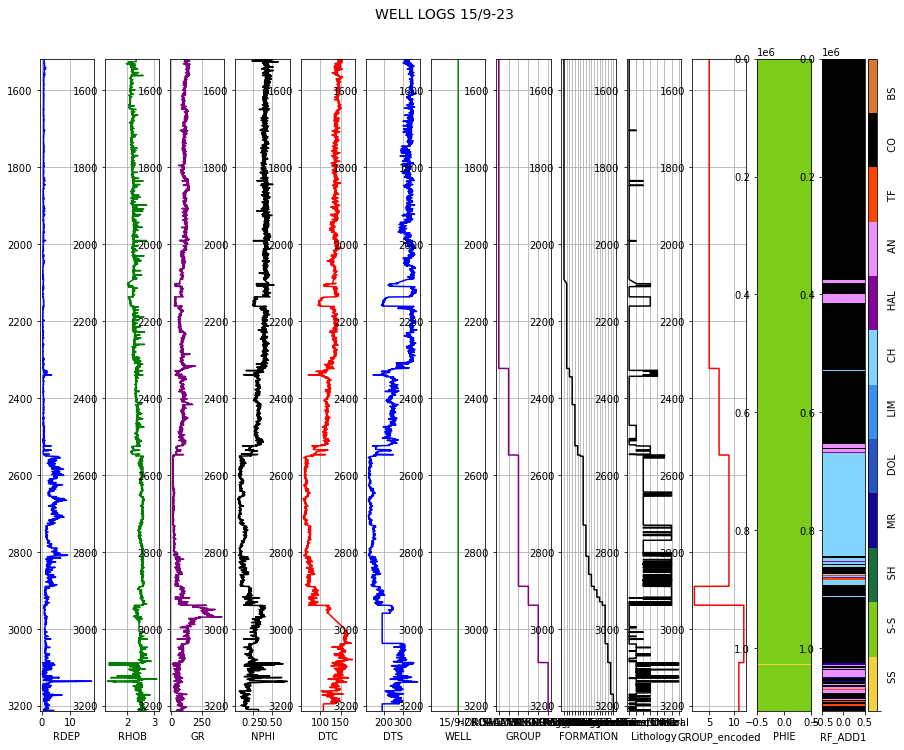

In [27]:
#Plotting predictions - HIDDEN DATASET
for i in range(1):
  pred_log(hidden_rf_tune, i, facies_colors, 1)